<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/5-ImageClass/ArchitecturesAdv/architec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Githubdan data indir

Bu dataset kaggledan alınmış FER 2013 challenge datasıdır.  modelleri zorladığı için kullanması keyifli


 Hızlı demo için densenet ve efficienNeti atla onlar uzun sürede eğitiliyor
https://www.kaggle.com/datasets/msambare/fer2013?resource=download

In [1]:
!wget https://github.com/onuralpArsln/MlAiTutorialProjects/raw/main/5-ImageClass/Fer2013Kaggle.zip -q -O data.zip

In [2]:
!unzip -q data.zip

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!pip -q install visualkeras
!pip -q install graphviz pydot

Python ile hızlıca datayı eğitim için hazırla

In [18]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, models


# 📂 Dataset ana klasörleri
test_dir = 'test'   # test/angry, test/disgust, test/fear ...
train_dir = 'train' # train/angry, train/disgust, train/fear ...

# 📌 Görselleri yükleyen fonksiyon (48x48 dataset için)
def load_images_from_directory(base_dir, label, img_size=(48, 48), limit=600):
    images = []
    labels = []
    count = 0
    for file_name in os.listdir(base_dir):
        if count >= limit:  # 300'den sonra dur
            break
        if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            file_path = os.path.join(base_dir, file_name)
            # grayscale yaptık çünkü kaynak grayscale
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size, color_mode="grayscale")
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # normalize
            images.append(img_array)
            labels.append(label)
            count += 1
    return images, labels

# Duygu klasörleri ve etiketleri
emotion_dirs = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "surprise": 5,
    "sad": 6
}

# --- Train verisi ---
train_images, train_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(train_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    train_images.extend(images)
    train_labels.extend(labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# --- Test verisi ---
test_images, test_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(test_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels


In [5]:
print("Elindeki veri miktarı ve test train dağlımı")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Elindeki veri miktarı ve test train dağlımı
X_train shape: (2100, 48, 48, 1)
X_test shape: (1911, 48, 48, 1)
y_train shape: (2100,)
y_test shape: (1911,)
Train samples: 2100
Test samples: 1911


Helper Functions

In [19]:
import time
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

import time
import tensorflow as tf

def compile_and_train_timed(model, name, epochs=100, batch_size=32, patience=5):
    """
    Compiles and trains the model with optional early stopping.
    Returns: model, history, training_time_in_seconds
    """
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # stop based on validation accuracy
        patience=patience,       # number of epochs to wait before stopping
        restore_best_weights=True,
        verbose=1
    )

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} training time: {training_time:.2f} seconds")

    return model, history, training_time


import tensorflow as tf

def get_flops(model, batch_size=1):
    """
    Calculate FLOPs for a Keras model.
    Returns total float operations (FLOPs).
    """
    # Make sure model is built
    if not model.built:
        model.build((None, 48, 48, 1))  # adjust input size if needed

    # Create concrete function
    concrete = tf.function(lambda inputs: model(inputs))
    concrete = concrete.get_concrete_function(
        tf.TensorSpec([batch_size] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )

    # Get frozen graph
    frozen_func = tf.graph_util.convert_variables_to_constants_v2(concrete)
    graph_def = frozen_func.graph.as_graph_def()

    # Run profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            graph=graph, run_meta=run_meta, cmd="op", options=opts
        )
    return flops.total_float_ops


In [7]:
# Tüm değişkenleri none olarak başlattık çünkü sadece bazı modelleri eğitsende graph bozulmasın
# Initialize all training histories
# Training histories
hist_cnn, hist_resnet, hist_densenet, hist_eff, hist_se, hist_vit = [None]*6

# Models
cnn, resnet, densenet, efficientnet, cnn_se, vit = [None]*6

# Training times
time_cnn, time_resnet, time_densenet, time_eff, time_se, time_vit = [None]*6



### CNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,279 (4.36 MB)

 Trainable params: 1,142,279 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


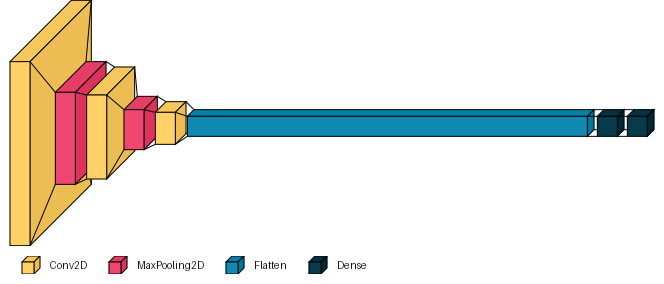

In [20]:
def build_cnn(input_shape=(48,48,1), num_classes=7):
    return models.Sequential([
        layers.Conv2D(32,3,activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3,activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])

cnn_model = build_cnn()

# Summary
cnn_model.summary()
tf.keras.utils.plot_model(cnn_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Plot model architecture
tf.keras.utils.plot_model(
    cnn_model, to_file="cnn_model.png",
    show_shapes=True, show_layer_names=True, dpi=80
)
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(cnn_model, legend=True, to_file="cnn_visual.png")




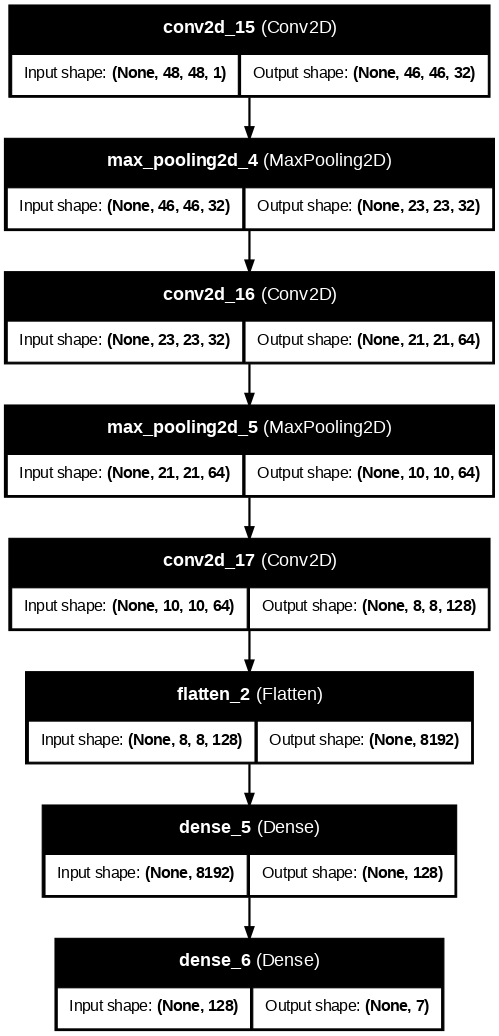

In [19]:
tf.keras.utils.plot_model(cnn_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [21]:
# train
cnn, hist_cnn, time_cnn = compile_and_train_timed(cnn_model, "CNN")

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1511 - loss: 1.9441 - val_accuracy: 0.2511 - val_loss: 1.8548
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2410 - loss: 1.8715 - val_accuracy: 0.3212 - val_loss: 1.7634
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3104 - loss: 1.7497 - val_accuracy: 0.3422 - val_loss: 1.6834
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4032 - loss: 1.5925 - val_accuracy: 0.3546 - val_loss: 1.6395
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4463 - loss: 1.4861 - val_accuracy: 0.3762 - val_loss: 1.6211
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4942 - loss: 1.3671 - val_accuracy: 0.3929 - val_loss: 1.6110
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5583 - loss: 1.1973 - val_accuracy: 0.3875 - val_loss: 1.6567
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6151 - loss: 1.0641 - val_ac

### ResNet

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 48, 48,    │      9,248 │ conv2d_47[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_24[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 48, 48,    │          0 │ add_22[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_25[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_26[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 48, 48,    │          0 │ add_23[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 24, 24,    │     18,496 │ re_lu_27[0][0]  

 Total params: 852,039 (3.25 MB)

 Trainable params: 849,223 (3.24 MB)

 Non-trainable params: 2,816 (11.00 KB)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 48, 48,    │      9,248 │ conv2d_47[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_24[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 48, 48,    │          0 │ add_22[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_25[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_26[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 48, 48,    │          0 │ add_23[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 24, 24,    │     18,496 │ re_lu_27[0][0]  

 Total params: 852,039 (3.25 MB)

 Trainable params: 849,223 (3.24 MB)

 Non-trainable params: 2,816 (11.00 KB)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


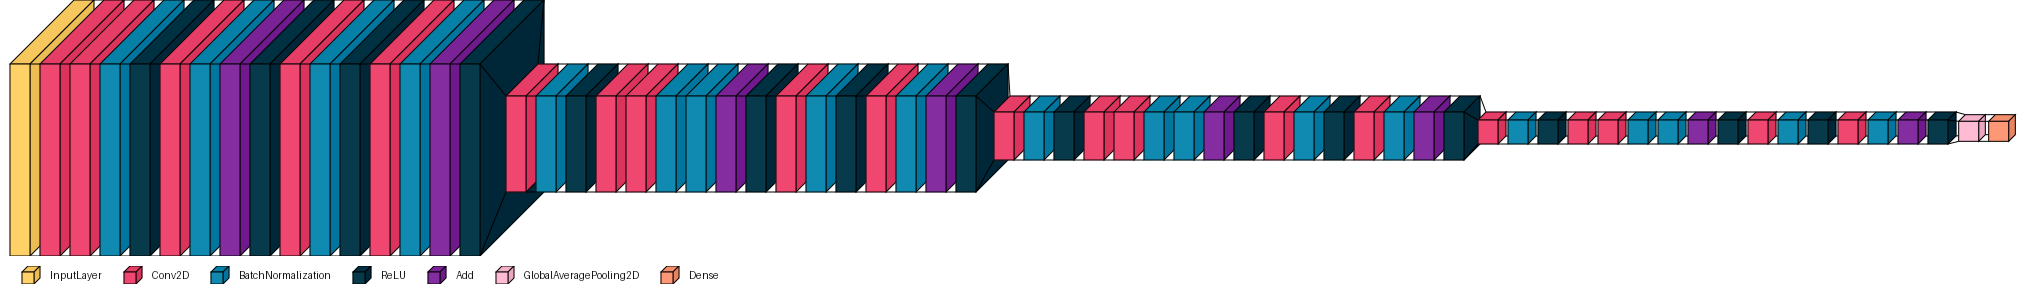

In [31]:
from tensorflow.keras import layers, models

def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    return layers.ReLU()(x)

def build_resnet(input_shape=(48,48,1), num_classes=7,
                 filters_list=[32, 64, 128], blocks_per_stage=[1,1,1]):
    """
    Build a customizable ResNet.
    filters_list: list of filters for each stage
    blocks_per_stage: list of how many residual blocks per stage
    """
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters_list[0], 3, padding='same', activation='relu')(inp)

    for stage, (filters, n_blocks) in enumerate(zip(filters_list, blocks_per_stage)):
        for block in range(n_blocks):
            stride = 2 if block == 0 and stage != 0 else 1
            x = residual_block(x, filters, stride=stride)

    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

# Example usage:
resnet_model = build_resnet(filters_list=[32,64,64,128], blocks_per_stage=[2,2,2,2])
resnet_model.summary()


# Summary
resnet_model.summary()

# Keras plot
tf.keras.utils.plot_model(resnet_model, to_file="resnet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(resnet_model, legend=True, to_file="resnet_visual.png")


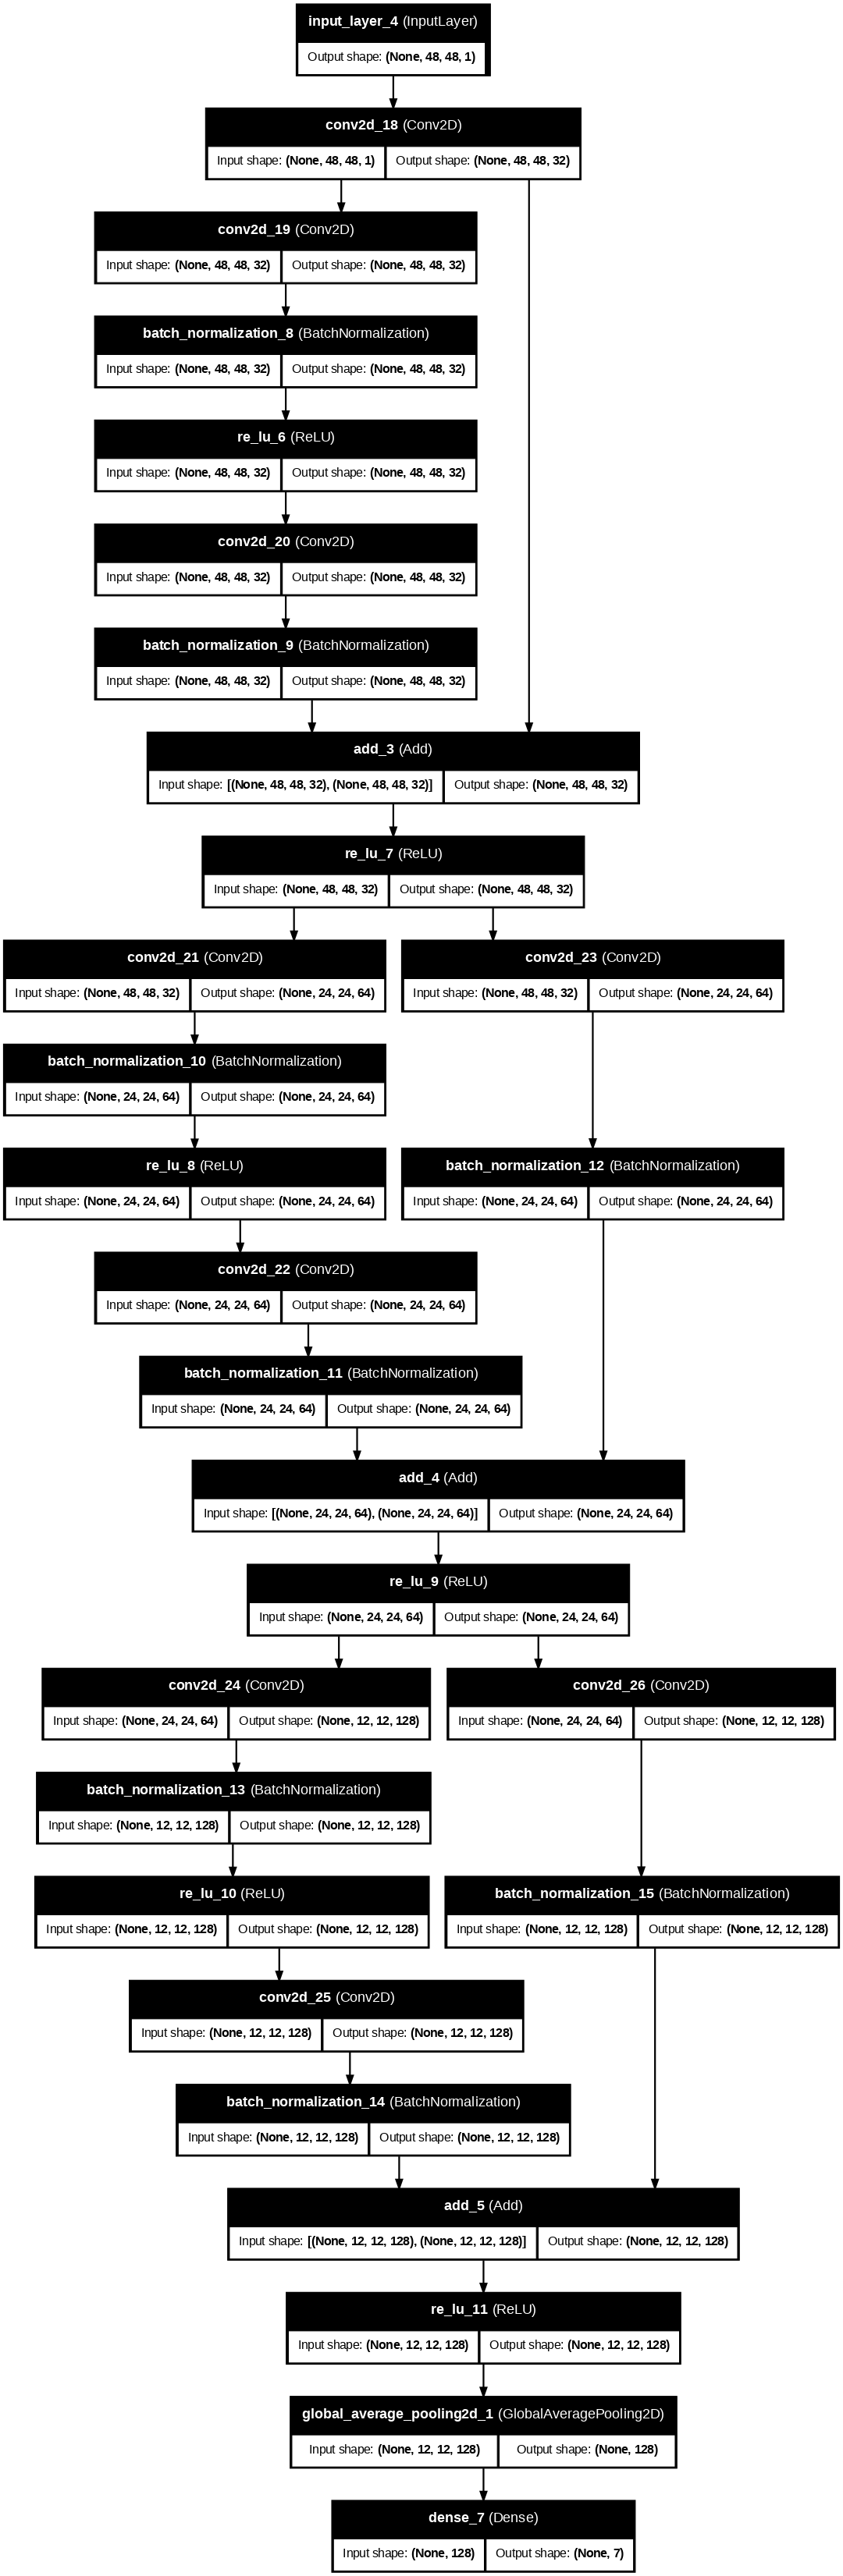

In [22]:
tf.keras.utils.plot_model(resnet_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [32]:
# train
resnet, hist_resnet, time_resnet = compile_and_train_timed(resnet_model, "ResNet")


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.1825 - loss: 2.0277 - val_accuracy: 0.1617 - val_loss: 2.3552
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3353 - loss: 1.7007 - val_accuracy: 0.0781 - val_loss: 2.5244
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4273 - loss: 1.4970 - val_accuracy: 0.1962 - val_loss: 2.0650
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4998 - loss: 1.3480 - val_accuracy: 0.3457 - val_loss: 1.7496
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5590 - loss: 1.1768 - val_accuracy: 0.3228 - val_loss: 1.8700
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6366 - loss: 0.9970 - val_accuracy: 0.2371 - val_loss: 3.1957
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7089 - loss: 0.8167 - val_accuracy: 0.2199 - val_loss: 3.7477
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8033 - loss: 0.5850 

### DenseNet

Model: "CustomDenseNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 48, 48,    │        160 │ input_layer_15[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_133[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_77 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 48, 48, 8) │      1,160 │ re_lu_77[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_93      │ (None, 48, 48,    │          0 │ conv2d_133[0][0], │
│ (Concatenate)       │ 24)               │            │ conv2d_134[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         96 │ concatenate_93[0… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_78 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 48, 48, 8) │      1,736 │ re_lu_78[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_94      │ (None, 48, 48,    │          0 │ concatenate_93[0… │
│ (Concatenate)       │ 32)               │            │ conv2d_135[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ concatenate_94[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_79 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 48, 48, 8) │      2,312 │ re_lu_79[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_95      │ (None, 48, 48,    │          0 │ concatenate_94[0… │
│ (Concatenate)       │ 40)               │            │ conv2d_136[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        160 │ concatenate_95[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_80 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 48, 48, 8) │      2,888 │ re_lu_80[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_96      │ (None, 48, 48,    │          0 │ concatenate_95[0… │
│ (Concatenate)       │ 48)               │            │ conv2d_137[0][0]

 Total params: 117,144 (457.59 KB)

 Trainable params: 113,920 (445.00 KB)

 Non-trainable params: 3,224 (12.59 KB)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


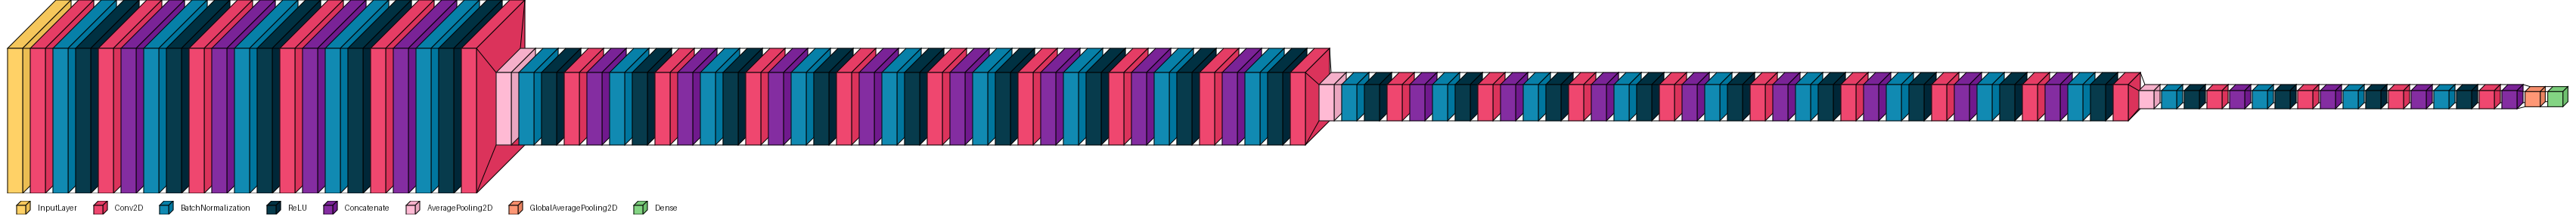

In [47]:
from tensorflow.keras import layers, models

def dense_layer(x, growth_rate):
    """A single dense layer: BN -> ReLU -> Conv(3x3)."""
    x1 = layers.BatchNormalization()(x)
    x1 = layers.ReLU()(x1)
    x1 = layers.Conv2D(growth_rate, (3,3), padding="same")(x1)
    return layers.Concatenate()([x, x1])

def dense_block(x, num_layers, growth_rate):
    """Stack multiple dense layers."""
    for _ in range(num_layers):
        x = dense_layer(x, growth_rate)
    return x

def transition_layer(x, compression=0.5):
    """Reduce channels and downsample spatial dims."""
    reduced_filters = int(x.shape[-1] * compression)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(reduced_filters, (1,1), padding="same")(x)
    x = layers.AveragePooling2D((2,2), strides=2)(x)
    return x

def build_simple_densenet(
        input_shape=(48,48,1),
        num_classes=7,
        growth_rate=12,
        block_layers=[4,4,4],  # how many dense layers in each block
        compression=0.5
    ):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(growth_rate*2, (3,3), padding="same")(inputs)

    for i, num_layers in enumerate(block_layers):
        x = dense_block(x, num_layers, growth_rate)
        if i != len(block_layers)-1:  # no transition after last block
            x = transition_layer(x, compression)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="CustomDenseNet")


# Build and summarize
densenet_model = build_simple_densenet(input_shape=(48,48,1),
                              num_classes=10,
                              growth_rate=8,
                              block_layers=[4,8,8,4])

# Summary
densenet_model.summary()

# Keras plot
tf.keras.utils.plot_model(densenet_model, to_file="densenet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(densenet_model, legend=True, to_file="densenet_visual.png")


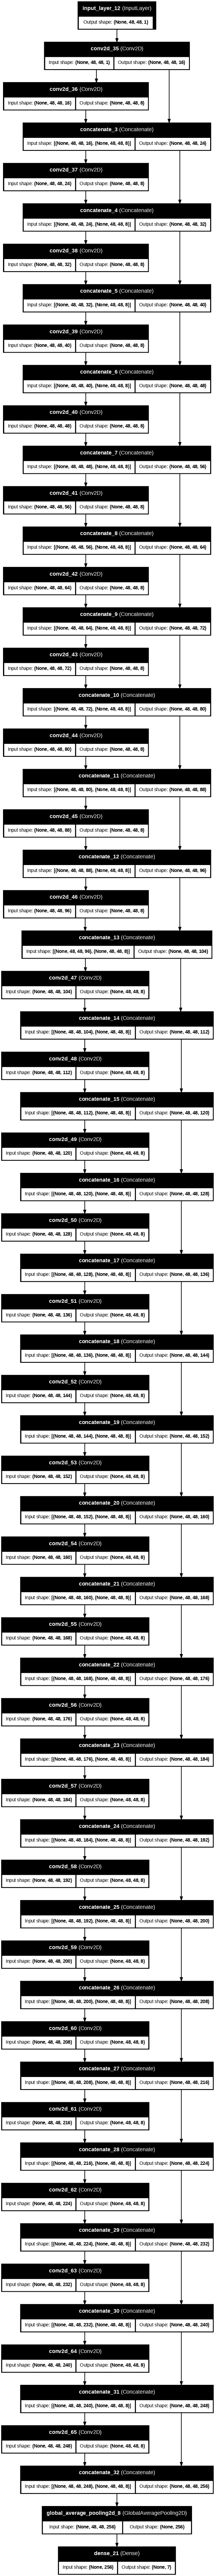

In [42]:
tf.keras.utils.plot_model(densenet_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [48]:
densenet, hist_densenet, time_densenet = compile_and_train_timed(densenet_model, "DenseNet")


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 477ms/step - accuracy: 0.1545 - loss: 2.0840 - val_accuracy: 0.0926 - val_loss: 2.0522
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1955 - loss: 1.9382 - val_accuracy: 0.1565 - val_loss: 2.0598
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2196 - loss: 1.8985 - val_accuracy: 0.1565 - val_loss: 2.0670
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2726 - loss: 1.8592 - val_accuracy: 0.1481 - val_loss: 2.2141
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2988 - loss: 1.8131 - val_accuracy: 0.1847 - val_loss: 2.4080
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3025 - loss: 1.7522 - val_accuracy: 0.2182 - val_loss: 1.9857
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3801 - loss: 1.6436 - val_accuracy: 0.2622 - val_loss: 1.8582
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3978 - loss: 1.5490 - val_accuracy: 0.1795 -

### EfficientNet

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_118     │ (None, 48, 48, 3) │          0 │ input_layer_17[0… │
│ (Concatenate)       │                   │            │ input_layer_17[0… │
│                     │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 48, 48, 3) │          0 │ concatenate_118[… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 48, 48, 3) │          7 │ rescaling_2[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ normalization_2[… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 4,016,515 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_118     │ (None, 48, 48, 3) │          0 │ input_layer_17[0… │
│ (Concatenate)       │                   │            │ input_layer_17[0… │
│                     │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 48, 48, 3) │          0 │ concatenate_118[… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 48, 48, 3) │          7 │ rescaling_2[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ normalization_2[… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 4,016,515 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


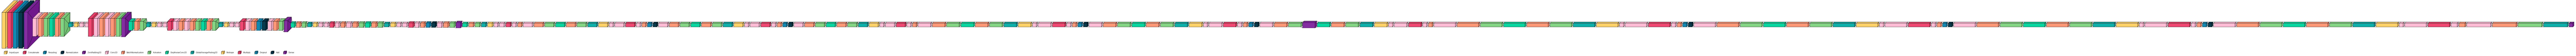

In [53]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2

def build_efficientnet(input_shape=(48,48,1), num_classes=7, variant='B2'):
    """
    Build an EfficientNet variant with controllable depth.
    variant: 'B0', 'B1', 'B2' etc.
    input_shape: (H, W, 1) grayscale
    """
    # Map variant string to class
    variants = {
        'B0': EfficientNetB0,
        'B1': EfficientNetB1,
        'B2': EfficientNetB2
        # add more if needed
    }
    EfficientNetClass = variants.get(variant, EfficientNetB0)

    # Convert 1-channel to 3-channel by repeating
    inputs = layers.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs]) if input_shape[-1] == 1 else inputs

    # Base model
    base = EfficientNetClass(weights=None, include_top=False, input_tensor=x)
    y = layers.GlobalAveragePooling2D()(base.output)
    outputs = layers.Dense(num_classes, activation='softmax')(y)

    return models.Model(inputs, outputs, name=f"EfficientNet{variant}")

# Example usage:
efficientnet_model = build_efficientnet(variant='B0')
efficientnet_model.summary()


# Summary
efficientnet_model.summary()

# Keras plot
tf.keras.utils.plot_model(efficientnet_model, to_file="efficientnet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(efficientnet_model, legend=True, to_file="efficientnet_visual.png")


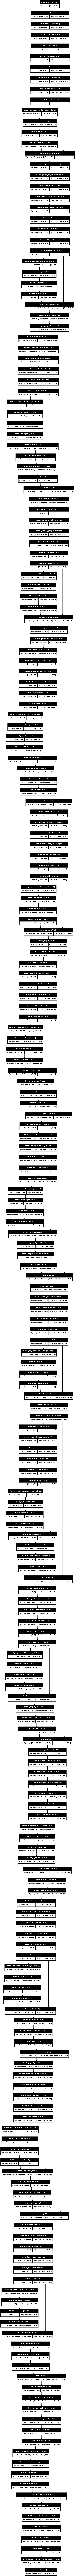

In [28]:
tf.keras.utils.plot_model(efficientnet_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [29]:
# train
efficientnet, hist_eff, time_eff = compile_and_train_timed(efficientnet_model, "EfficientNet")


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 144s 966ms/step - accuracy: 0.1523 - loss: 2.2557 - val_accuracy: 0.1570 - val_loss: 1.9419
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1711 - loss: 2.1317 - val_accuracy: 0.1570 - val_loss: 1.9446
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2256 - loss: 1.9258 - val_accuracy: 0.1570 - val_loss: 1.9309
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3382 - loss: 1.8150 - val_accuracy: 0.1570 - val_loss: 1.9488
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3888 - loss: 1.6463 - val_accuracy: 0.1570 - val_loss: 1.9274
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4975 - loss: 1.4532 - val_accuracy: 0.1591 - val_loss: 2.0258
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5644 - loss: 1.2685 - val_accuracy: 0.1570 - val_loss: 2.1134
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6641 - loss: 1.0263 - val_accuracy: 0.1664 

### CNN + SE (Attention)

In [ ]:
def se_block(x, ratio=8):
    f = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(f//ratio,activation='relu')(se)
    se = layers.Dense(f,activation='sigmoid')(se)
    se = layers.Reshape((1,1,f))(se)
    return layers.multiply([x,se])

def build_cnn_se(input_shape=(48,48,1), num_classes=7):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = se_block(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = se_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return models.Model(inp,out)

cnn_se_model = build_cnn_se()

# Summary
cnn_se_model.summary()

# Keras plot
tf.keras.utils.plot_model(cnn_se_model, to_file="cnn_se_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(cnn_se_model, legend=True, to_file="cnn_se_visual.png")


In [ ]:
tf.keras.utils.plot_model(cnn_se_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [25]:
# Train
cnn_se, hist_se, time_se = compile_and_train_timed(cnn_se_model, "CNN-SE")


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1561 - loss: 1.9436 - val_accuracy: 0.1633 - val_loss: 1.9200
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1623 - loss: 1.9397 - val_accuracy: 0.1973 - val_loss: 1.9105
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1713 - loss: 1.9342 - val_accuracy: 0.1986 - val_loss: 1.8966
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1671 - loss: 1.9275 - val_accuracy: 0.2102 - val_loss: 1.8940
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1753 - loss: 1.9255 - val_accuracy: 0.2091 - val_loss: 1.8866
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1931 - loss: 1.9159 - val_accuracy: 0.2002 - val_loss: 1.8839
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1956 - loss: 1.9142 - val_accuracy: 0.2167 - val_loss: 1.8820
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1966 - loss: 1.9123 - val_acc

### Vision Transformer

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 48, 48, 3) │          6 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 8, 8, 64)  │      6,976 │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 64, 64)    │          0 │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 64, 64)    │          0 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ add_11[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64)    │          0 │ add_11[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64, 64)    │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64, 64)    │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 173,837 (679.05 KB)

 Trainable params: 173,837 (679.05 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


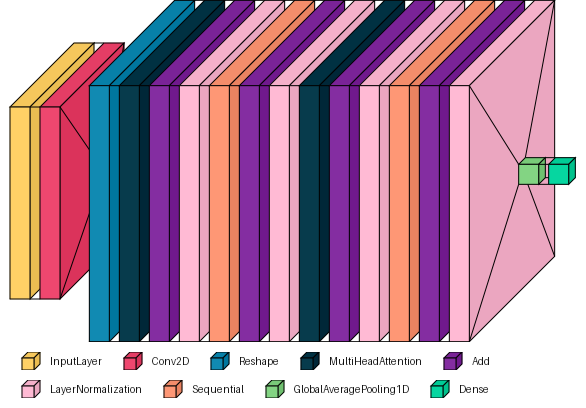

In [26]:
def build_vit(input_shape=(48,48,1), num_classes=7,
              patch_size=6, num_heads=4, proj_dim=64, layers_num=2):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(3,1)(inp)  # convert grayscale -> 3 channels
    patches = layers.Conv2D(proj_dim, patch_size, strides=patch_size)(x)
    patches = layers.Reshape((-1,proj_dim))(patches)
    positions = tf.range(start=0, limit=patches.shape[1], delta=1)
    pos_emb = layers.Embedding(input_dim=patches.shape[1], output_dim=proj_dim)(positions)
    x = patches + pos_emb
    for _ in range(layers_num):
        attn = layers.MultiHeadAttention(num_heads=num_heads,key_dim=proj_dim)(x,x)
        x = layers.Add()([x,attn])
        x = layers.LayerNormalization()(x)
        mlp = models.Sequential([layers.Dense(proj_dim*2,activation='relu'),
                                 layers.Dense(proj_dim)])
        x = layers.Add()([x,mlp(x)])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return models.Model(inp,out)

vit_model = build_vit()

# Summary
vit_model.summary()

# Keras plot
tf.keras.utils.plot_model(vit_model, to_file="vit_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(vit_model, legend=True, to_file="vit_visual.png")


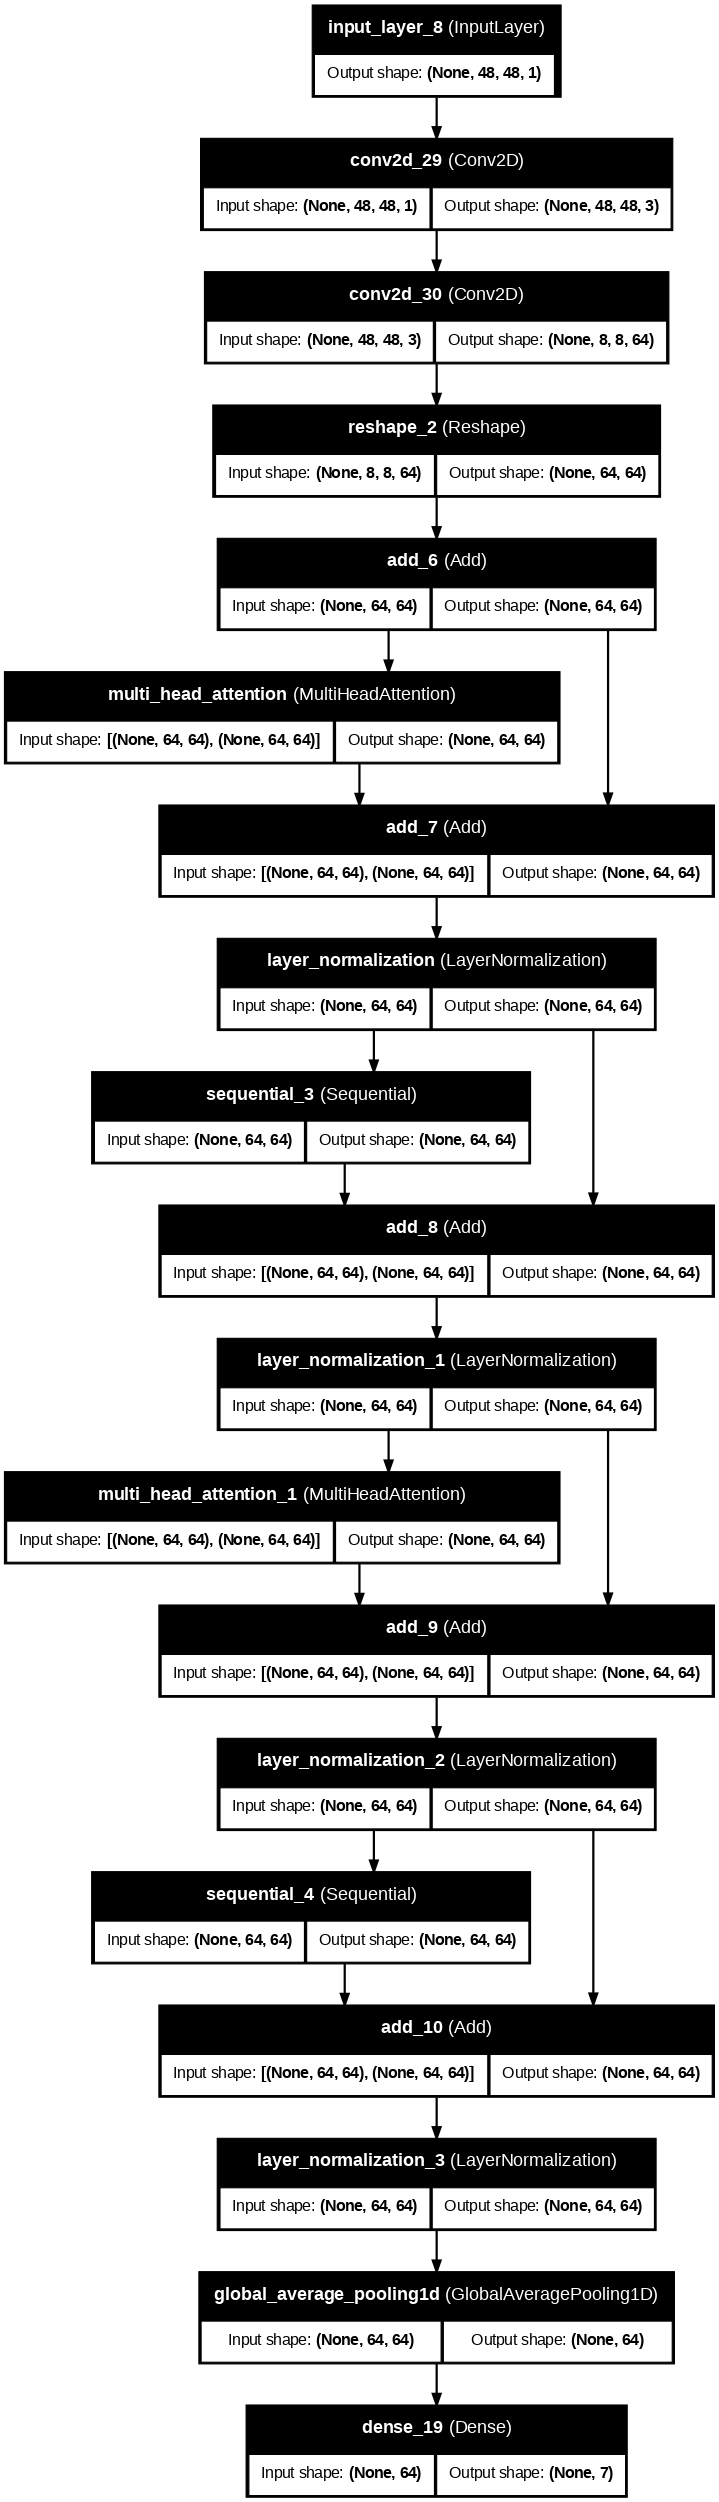

In [34]:
tf.keras.utils.plot_model(vit_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)


In [27]:
# Train
vit, hist_vit, time_vit = compile_and_train_timed(vit_model, "ViT")

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.1375 - loss: 2.0914 - val_accuracy: 0.1617 - val_loss: 1.9132
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1557 - loss: 1.9735 - val_accuracy: 0.1620 - val_loss: 1.9341
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1483 - loss: 1.9612 - val_accuracy: 0.1932 - val_loss: 1.8893
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1723 - loss: 1.9514 - val_accuracy: 0.1849 - val_loss: 1.9300
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1807 - loss: 1.9437 - val_accuracy: 0.1954 - val_loss: 1.8787
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1729 - loss: 1.9349 - val_accuracy: 0.1762 - val_loss: 1.9114
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1873 - loss: 1.9304 - val_accuracy: 0.1892 - val_loss: 1.9006
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1925 - loss: 1.9291 - val_

### Compare Models

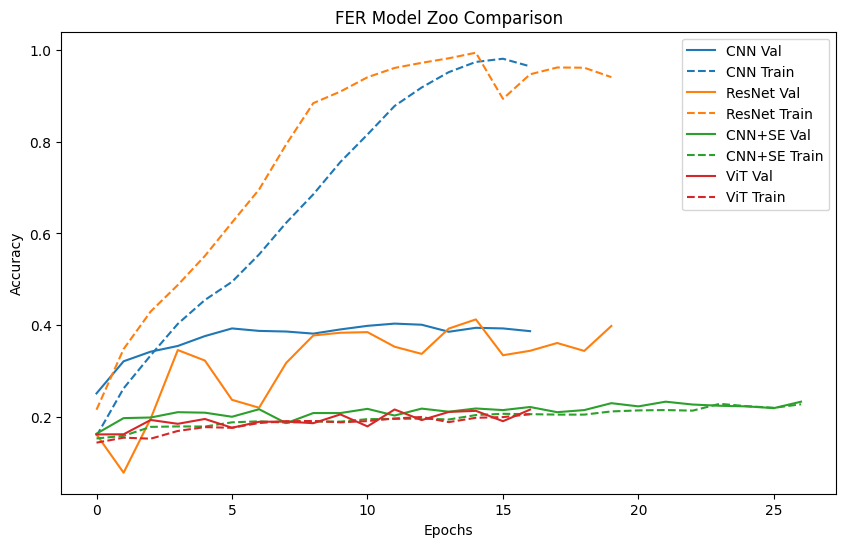

CNN: Params=1,142,279, Training time=21.5s
ResNet: Params=852,039, Training time=103.3s
CNN+SE: Params=20,659, Training time=31.8s
ViT: Params=173,837, Training time=34.6s


In [33]:

histories = {
    "CNN": hist_cnn,
    "ResNet": hist_resnet,
    "DenseNet": hist_densenet,
    "EfficientNet": hist_eff,
    "CNN+SE": hist_se,
    "ViT": hist_vit
}

models_dict = {
    "CNN": cnn,
    "ResNet": resnet,
    "DenseNet": densenet,
    "EfficientNet": efficientnet,
    "CNN+SE": cnn_se,
    "ViT": vit
}

training_times = {
    "CNN": time_cnn,
    "ResNet": time_resnet,
    "DenseNet": time_densenet,
    "EfficientNet": time_eff,
    "CNN+SE": time_se,
    "ViT": time_vit
}

import matplotlib.pyplot as plt

# Filter out None entries in case some models weren't trained
trained_histories = {k:v for k,v in histories.items() if v is not None}
trained_models = {k:v for k,v in models_dict.items() if k in trained_histories}
trained_times = {k:v for k,v in training_times.items() if k in trained_histories}

# Plot accuracies
plt.figure(figsize=(10,6))
for name, h in trained_histories.items():
    # Validation accuracy (solid line)
    plt.plot(h.history['val_accuracy'], label=f"{name} Val")
    # Training accuracy (dotted line, same color)
    color = plt.gca().lines[-1].get_color()
    plt.plot(h.history['accuracy'], linestyle='--', color=color, label=f"{name} Train")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FER Model Zoo Comparison")
plt.legend()
plt.show()

# Print parameters and training times
for name, m in trained_models.items():
    if not m.built:
        m.build((None, 48, 48, 1))  # ensure model is built
    print(f"{name}: Params={m.count_params():,}, Training time={trained_times[name]:.1f}s")



### Random Predictions

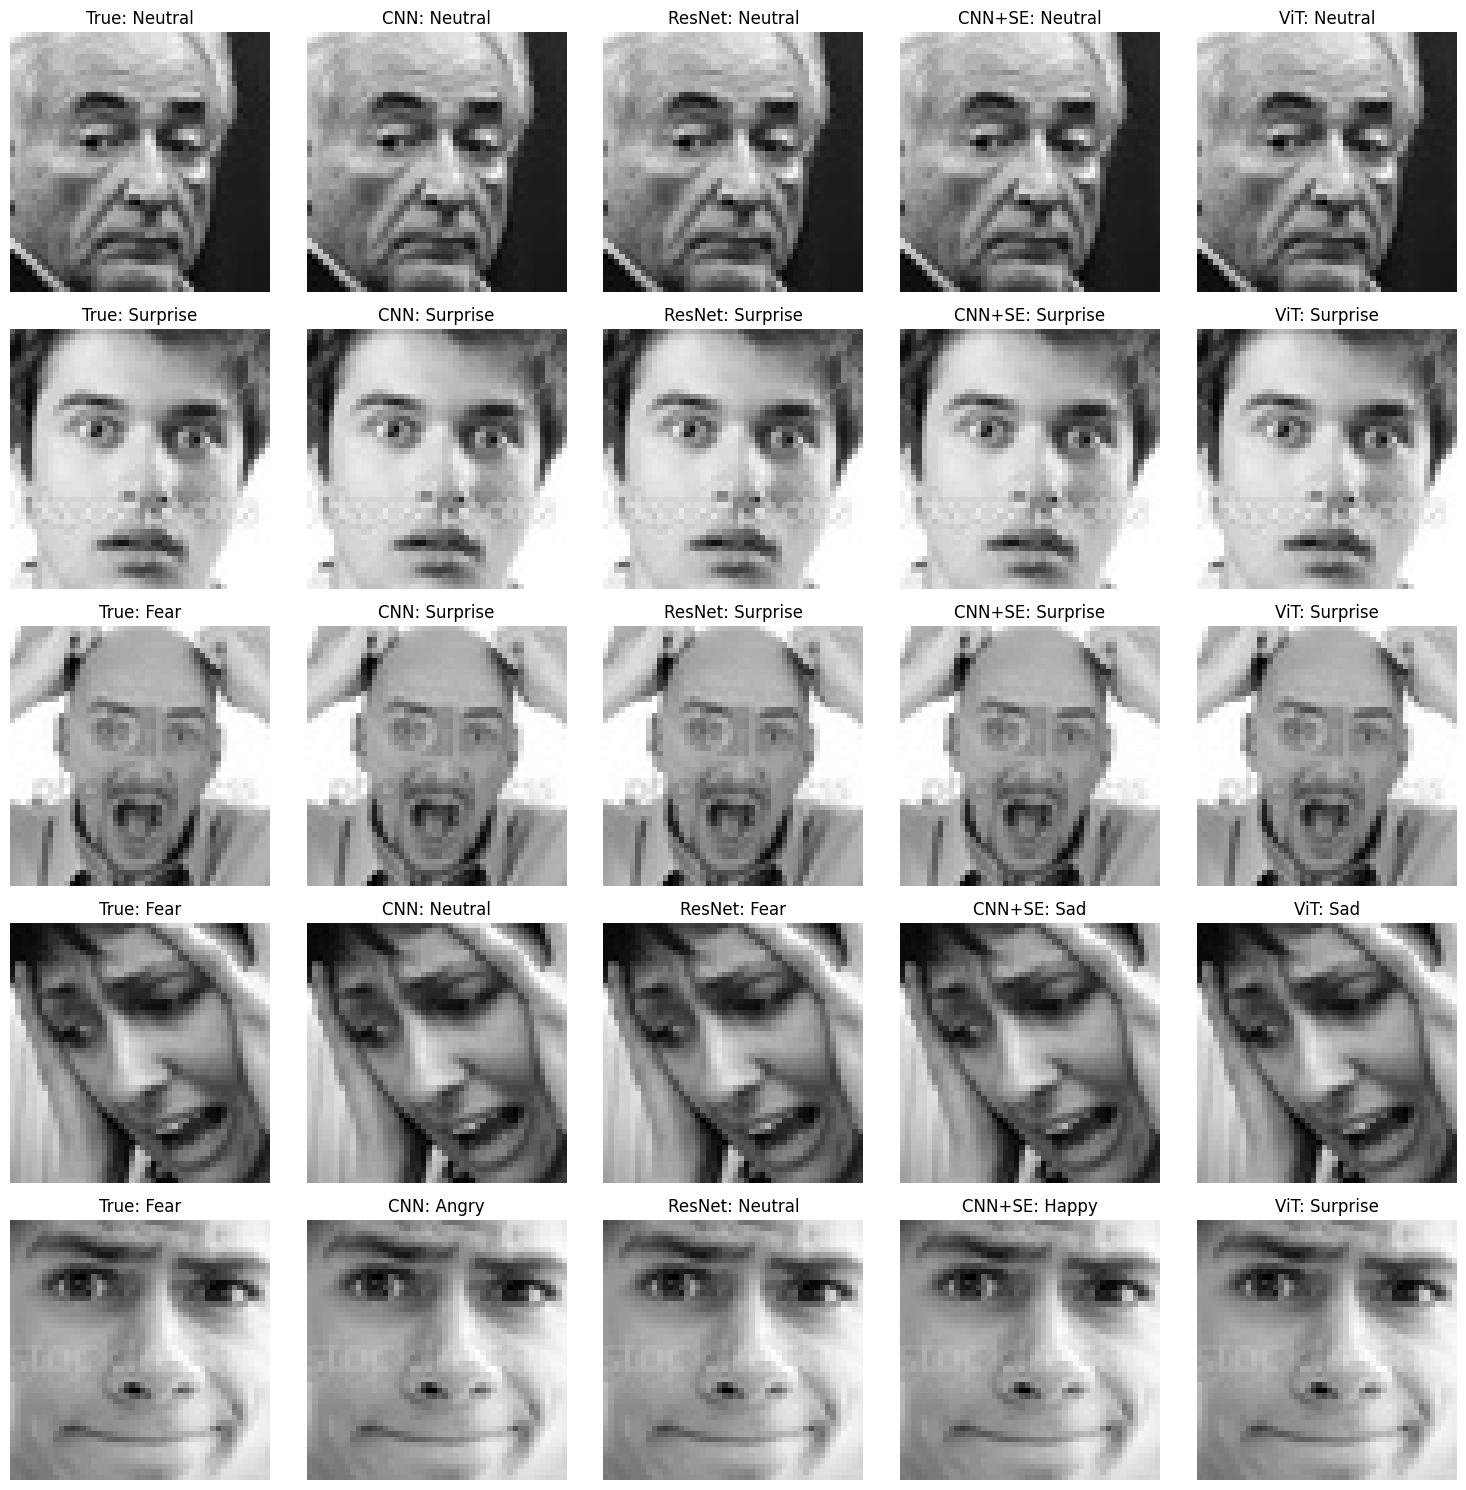

In [29]:
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_predictions(models_dict, X, y, num_images=5):
    # Filter out models that are not trained
    trained_models = {name: model for name, model in models_dict.items() if model is not None}
    if not trained_models:
        print("No trained models to display!")
        return

    idxs = random.sample(range(len(X)), num_images)
    fig, axes = plt.subplots(num_images, len(trained_models)+1, figsize=(3*(len(trained_models)+1), 3*num_images))

    # Ensure axes is always 2D array
    if num_images == 1:
        axes = axes[np.newaxis, :]
    if len(trained_models) == 1:
        axes = axes[:, np.newaxis]

    for i, idx in enumerate(idxs):
        img, true_label = X[idx], emotion_labels[y[idx]]
        axes[i,0].imshow(img.squeeze(), cmap='gray')
        axes[i,0].set_title(f"True: {true_label}")
        axes[i,0].axis("off")

        for j, (name, model) in enumerate(trained_models.items(), start=1):
            pred = model.predict(img[np.newaxis,...], verbose=0)
            pred_label = emotion_labels[np.argmax(pred)]
            axes[i,j].imshow(img.squeeze(), cmap='gray')
            axes[i,j].set_title(f"{name}: {pred_label}")
            axes[i,j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
show_random_predictions(models_dict, X_test, y_test)



### Test on your Image

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_custom(models_dict, filepath, target_size=(48,48)):
    img = image.load_img(filepath, target_size=target_size, color_mode="grayscale")
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, axis=0)
    plt.imshow(arr[0].squeeze(), cmap='gray')
    plt.axis("off"); plt.title("Custom image"); plt.show()
    for name, model in models_dict.items():
        pred = model.predict(arr, verbose=0)
        print(f"{name}: {emotion_labels[np.argmax(pred)]}")

# Example:
# predict_custom(models_dict, "my_face.png")
